In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-`1qonly "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet
/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import os


import lightgbm
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import pandas as pd
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay, accuracy_score

import shap
import itertools

In [3]:
train = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet")
test = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet")
train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")
#submission = pd.read_csv("/kaggle/input/amex-default-prediction/sample_submission.csv")


In [4]:
train.shape, test.shape, train_labels.shape

((5531451, 190), (11363762, 190), (458913, 2))

In [5]:
train.duplicated().sum()

0

In [6]:
for col in train.columns.values:
  print(col,'-',train[col].isna().sum()/len(train[col]))

customer_ID - 0.0
S_2 - 0.0
P_2 - 0.008313370216964771
D_39 - 0.0
B_1 - 0.0
B_2 - 0.00036446133211701597
R_1 - 0.0
S_3 - 0.1844984254583472
D_41 - 0.00036446133211701597
B_3 - 0.00036446133211701597
D_42 - 0.8569427804747796
D_43 - 0.29981211078250536
D_44 - 0.0
B_4 - 0.0
D_45 - 0.000364642116507947
B_5 - 0.0
R_2 - 0.0
D_46 - 0.21905626570677386
D_47 - 0.0
D_48 - 0.12993426137192574
D_49 - 0.0
B_6 - 4.212276308693686e-05
B_7 - 0.0
B_8 - 0.004025706817252833
D_50 - 0.5680972316305433
D_51 - 0.0
B_9 - 0.0
R_3 - 0.0
D_52 - 0.005344528949094912
P_3 - 0.05450504759058699
B_10 - 0.0
D_53 - 0.7384292114311417
S_5 - 0.0
B_11 - 0.0
S_6 - 0.0
D_54 - 0.00036446133211701597
R_4 - 0.0
S_7 - 0.1844984254583472
B_12 - 0.0
S_8 - 0.0
D_55 - 0.03340949779723259
D_56 - 0.5407158085645158
B_13 - 0.008952262254515135
R_5 - 0.0
D_58 - 0.0
S_9 - 0.5303568629641662
B_14 - 0.0
D_59 - 0.0
D_60 - 0.0
D_61 - 0.10811846656510199
B_15 - 0.001251570338415725
S_11 - 0.0
D_62 - 0.137063674612683
D_63 - 0.0
D_64 - 0.0


In [7]:
non_numeric_cols = train.columns[train.dtypes == 'object'].values
non_numeric_cols

array(['customer_ID', 'S_2'], dtype=object)

In [8]:
numeric_cols = train.columns[train.dtypes != 'object'].values
numeric_cols

array(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47',
       'D_48', 'D_49', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3',
       'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4',
       'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9',
       'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_63',
       'D_64', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'D_66', 'B_20',
       'D_68', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70',
       'D_71', 'D_72', 'S_15', 'B_23', 'D_73', 'P_4', 'D_74', 'D_75',
       'D_76', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79',
       'R_8', 'R_9', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81',
       'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15',
       'D_84', 'R_16', 'B_29', 'B_30', 'S_18', 'D_86', 'D_87', 'R_17',
       'R_18', 'D_88', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20',
 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


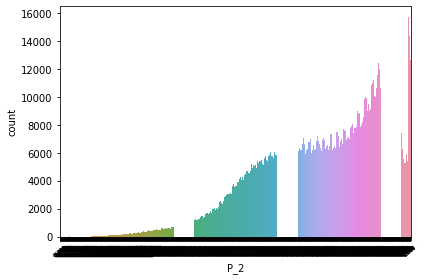

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


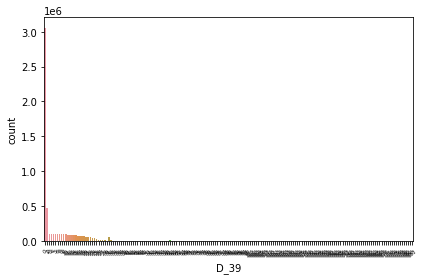

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


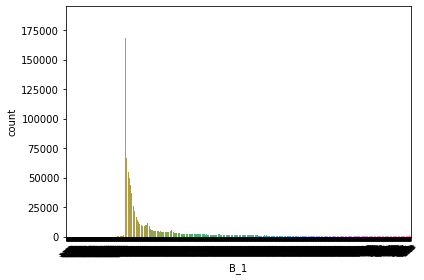

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


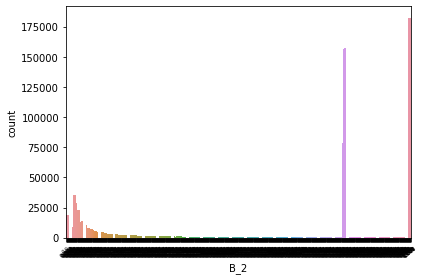

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


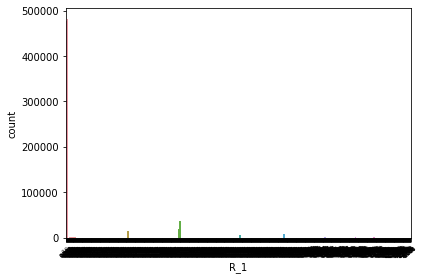

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


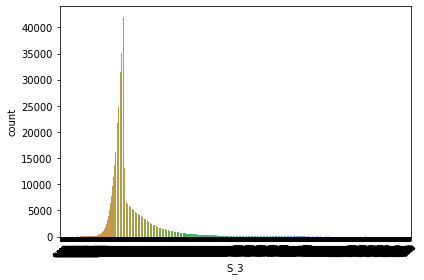

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


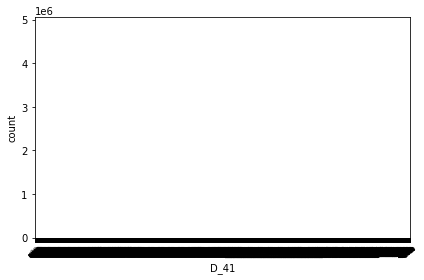

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


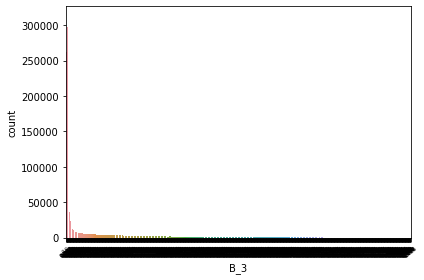

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


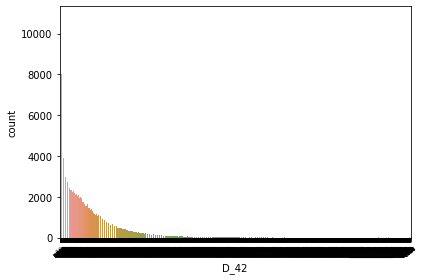

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


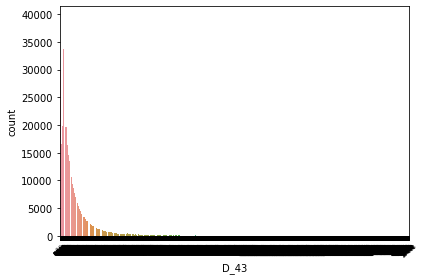

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


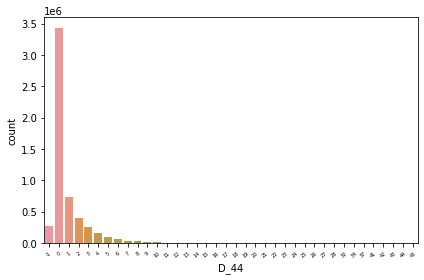

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


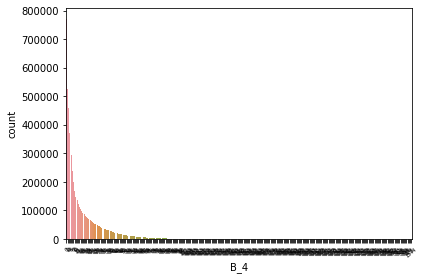

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


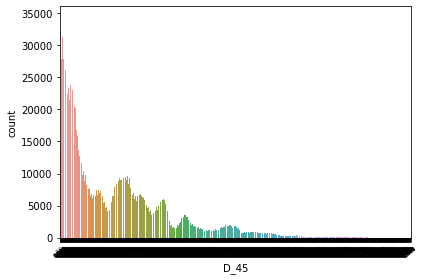

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


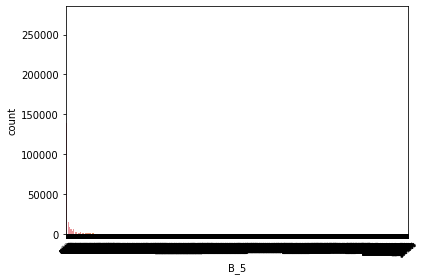

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


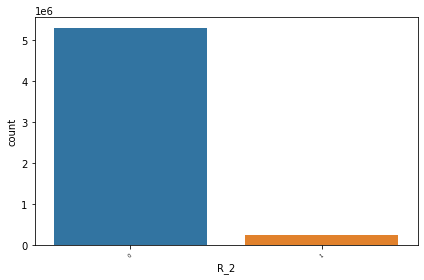

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


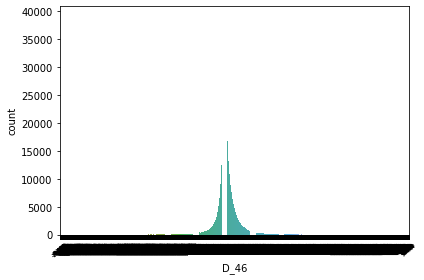

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


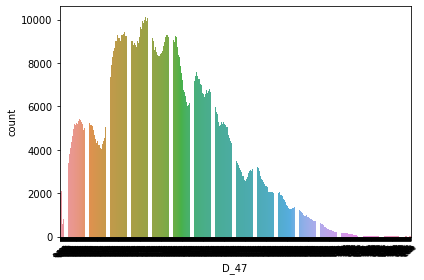

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


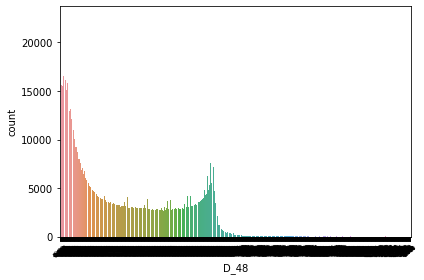

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


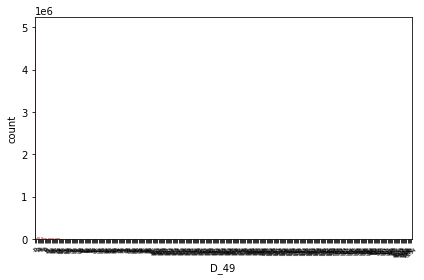

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


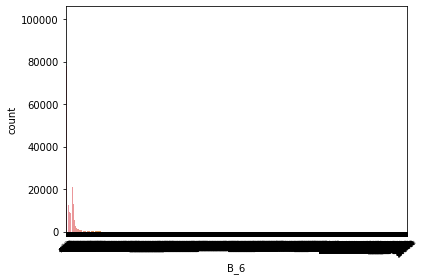

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


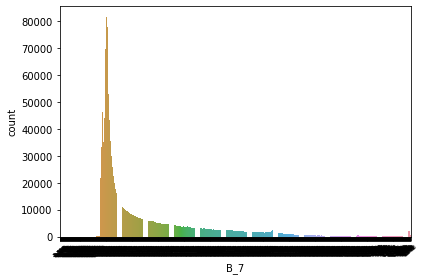

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


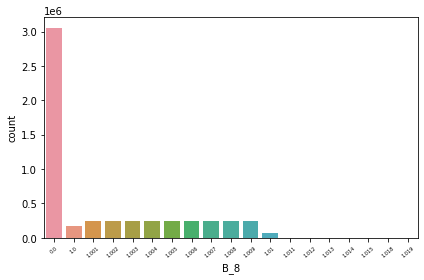

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


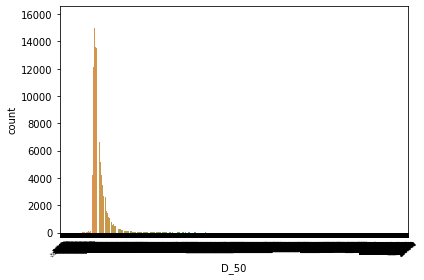

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


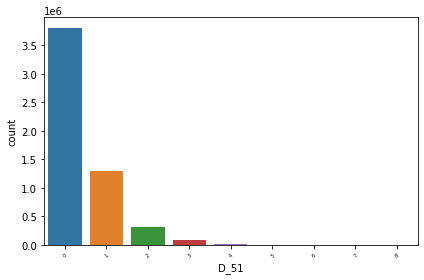

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


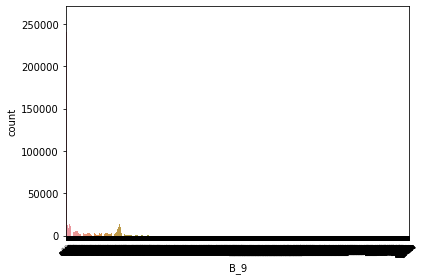

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


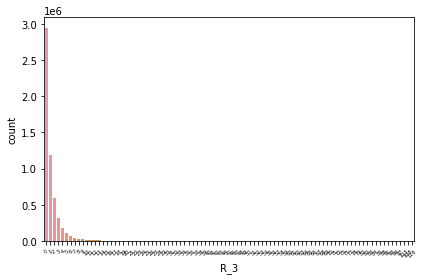

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


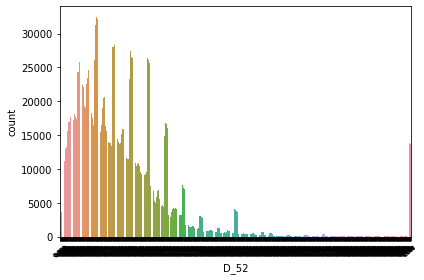

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


In [ ]:
import seaborn as sns
for i in numeric_cols:
    X = train[i].round(decimals = 3)
    plt.figure(i)
    ax = sns.countplot(X)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=5)
    plt.tight_layout()
    plt.show()

        

In [ ]:
import matplotlib.style as style
import seaborn as sns
style.use('seaborn-poster')
sns.set_style('ticks')
plt.subplots(figsize = (270,200))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(train.corr(), cmap=plt.get_cmap('Blues'), annot=True, mask=mask, center = 0, square=True, 
             );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 25);

In [ ]:
train.shape

In [ ]:
train['Date'] =  pd.to_datetime(train['S_2'], format="%Y/%m/%d")
train['weekday'] = train['Date'].dt.weekday
train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['year'] = train['Date'].dt.year

In [ ]:
train['S_2'] = pd.to_numeric(train['S_2'].str.replace('-',''))
train['S_2']

In [ ]:
train.drop(['Date'], axis=1, inplace=True)
train.shape

In [ ]:
cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68",'customer_ID']

In [ ]:
features = [col for col in train.columns.values if col not in cat_features]
features.append('customer_ID')

In [ ]:
for i in cat_features:
    if train[i].dtype == 'int64':
        train.astype('int16')

In [ ]:
train_cat = train[cat_features].groupby('customer_ID',as_index=False).agg(['count', 'last', 'nunique'])
train_cat.shape

In [ ]:
for i in train.columns:
    if train[i].dtype == 'float64':
        train.astype('float16')

In [ ]:
train.shape

In [ ]:
drop_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]

In [ ]:
train.drop(drop_features, axis=1, inplace=True)

In [ ]:
train = train.groupby('customer_ID',as_index=False).agg(['mean', 'std','sum', 'min','last'])

train.shape

In [ ]:
import gc
gc.collect()

In [ ]:
train.columns.values

In [ ]:
train = train.merge(train_cat, how='inner', on="customer_ID")
train.shape

In [ ]:
del train_cat

In [ ]:
join_col = []
for i in train.columns.values:
    if type(i) is tuple:
        col = '_'.join(i)
        join_col.append(col)
train.columns = join_col
train.reset_index()

In [ ]:
train = train.merge(train_labels, how='inner', on="customer_ID")
train.shape

In [ ]:
del train_labels

In [ ]:
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.98)]

# Drop features 

to_drop

In [ ]:
train.shape

In [ ]:
train.drop(to_drop, axis=1, inplace=True)
train.shape

In [ ]:
test.shape

In [ ]:
test['Date'] =  pd.to_datetime(test['S_2'], format="%Y/%m/%d")
test['weekday'] = test['Date'].dt.weekday
test['day'] = test['Date'].dt.day
test['month'] = test['Date'].dt.month
test['year'] = test['Date'].dt.year

In [ ]:
test['S_2'] = pd.to_numeric(test['S_2'].str.replace('-',''))
test['S_2']

In [ ]:
test.drop(['Date'], axis=1, inplace=True)
test.shape

In [ ]:
cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68",'customer_ID']

In [ ]:
for i in test.columns.values:
    if test[i].dtype == 'int64' and i == 'customer_ID':
        test.astype('int16')

In [ ]:
test.shape

In [ ]:
test_copy = test[cat_features].groupby('customer_ID',as_index=False).agg(['count', 'last', 'nunique'])

In [ ]:
for i in test.columns.values:
    if test[i].dtype == 'float64':
        test.astype('float16')

In [ ]:
drp_col = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [ ]:
test.drop(drp_col, axis=1, inplace=True)

In [ ]:
import gc
gc.collect()

In [ ]:
test.head()

In [ ]:
test = test.groupby('customer_ID',as_index=False).agg(['mean', 'std','sum','max',  'last'])
test.shape

In [ ]:
test.shape

In [ ]:
test = test.merge(test_copy, how='inner', on="customer_ID")


In [ ]:
join_col = []
for i in test.columns.values:
    if type(i) is tuple:
        col = '_'.join(i)
        join_col.append(col)
        
test.columns = join_col
test.reset_index()

In [ ]:
test.drop(to_drop, axis=1, inplace=True)
test.shape

In [ ]:
del test_copy


In [ ]:
gc.collect()

In [ ]:
target = train['target']
Features = train.drop('target', axis=1, inplace=False)
train.shape, Features.shape

In [ ]:
numeric_cols = Features.columns[Features.dtypes != "object"].values
non_numeric_cols = Features.columns[Features.dtypes == 'object'].values

In [ ]:
#test_1 = test.loc[:, Features.columns]
Features.shape, test.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

In [ ]:

numeric_preprocessing_steps = Pipeline(steps=[
    ('standard_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ])

non_numeric_preprocessing_steps = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    #('onehot', OrdinalEncoder())
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])


preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        #("non_numeric",non_numeric_preprocessing_steps,non_numeric_cols)
    ],
    remainder='drop'
)

In [ ]:
XGB = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1)

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
cat = CatBoostClassifier(iterations=3000, random_state=22,
                         learning_rate=0.03,
                         max_depth=9,
                         objective='Logloss',
                         subsample = 0.4,
                         colsample_bylevel=0.3
                        )

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(

    n_estimators= 3000, 
    num_leaves= 100,
    learning_rate= 0.01,
    colsample_bytree= 0.6,
    objective = 'binary',
    max_depth= 8,
    min_child_samples= 548,
    min_data_in_leaf = 27,
    bagging_freq = 7,
    bagging_fraction= 0.8,
    feature_fraction = 0.4,
    subsample = 0.8
)


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators_stacked = [
            
             ('cbc', cat),
            ('lgbm', lgbm),
              #('xbg', XGB)
]    
        


stacked_estimator =  StackingClassifier(estimators=estimators_stacked,
                                    final_estimator= LogisticRegression(),
                                    stack_method='predict_proba'
                                  )

In [ ]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", lgbm),
])

In [ ]:
full_pipeline.fit(Features,target)

In [ ]:

#import numpy as np
#np.mean(cross_val_score(full_pipeline, Features, train['target'], scoring='accuracy', cv=5))



In [ ]:
test.shape

In [ ]:
test.shape

In [ ]:
import gc
gc.collect()


In [ ]:
import joblib

joblib.dump(full_pipeline, 'pipe.joblib')



In [ ]:
import joblib
full_pipeline = joblib.load('pipe.joblib')

In [ ]:
test_probas = full_pipeline.predict_proba(test)

In [ ]:
tests = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet")

In [ ]:
tests = tests.groupby('customer_ID').tail(1)
tests.shape

In [ ]:
test_probas[:,1]

In [ ]:
tests['prediction']=test_probas[:,1]
tests['prediction']

In [ ]:
tests.shape

In [ ]:
sub = tests[['customer_ID','prediction']]
sub.shape

In [ ]:
sub.to_csv("my_submission.csv", index=False)
sub.head()

In [ ]:
test.shape